<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/ML-models/blob/main/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
import os
import numpy as np
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [15]:
# Mount Google Drive
drive.mount('/content/drive')

# Set dataset path
dataset_path = "/content/drive/MyDrive/Dataset4"

# Define training, validation, and test directories
train_dir = os.path.join(dataset_path, "Training")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Testing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Image size
IMG_SIZE = (224, 224)

# 📌 Step 2: Load & Preprocess Dataset
def load_images_and_create_pairs(directory):
    real_images = []
    fake_images = []

    # Load real and fake images
    real_path = os.path.join(directory, "Real")
    fake_path = os.path.join(directory, "Fake")

    for img_name in os.listdir(real_path):
        img = load_img(os.path.join(real_path, img_name), target_size=IMG_SIZE)
        real_images.append(img_to_array(img))

    for img_name in os.listdir(fake_path):
        img = load_img(os.path.join(fake_path, img_name), target_size=IMG_SIZE)
        fake_images.append(img_to_array(img))

    # Convert to numpy arrays & normalize
    real_images = np.array(real_images) / 255.0
    fake_images = np.array(fake_images) / 255.0

    pairs, labels = [], []

    # Create positive pairs (Real-Real)
    for i in range(len(real_images) - 1):
        pairs.append([real_images[i], real_images[i + 1]])
        labels.append(1)

    # Create negative pairs (Real-Fake)
    for i in range(min(len(real_images), len(fake_images))):
        pairs.append([real_images[i], fake_images[i]])
        labels.append(0)

    return np.array(pairs), np.array(labels)

In [17]:
# Load training and validation data
train_pairs, train_labels = load_images_and_create_pairs(train_dir)
val_pairs, val_labels = load_images_and_create_pairs(val_dir)

print(f"✅ Training Pairs: {train_pairs.shape}, Labels: {train_labels.shape}")
print(f"✅ Validation Pairs: {val_pairs.shape}, Labels: {val_labels.shape}")


✅ Training Pairs: (63, 2, 224, 224, 3), Labels: (63,)
✅ Validation Pairs: (16, 2, 224, 224, 3), Labels: (16,)


In [18]:
# 📌 Step 3: Build the Siamese Network
def build_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def build_siamese_network(input_shape):
    base_network = build_base_network(input_shape)

    # Inputs
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Extract features
    feature_a = base_network(input_a)
    feature_b = base_network(input_b)

    # Compute absolute difference
    def euclidean_distance(vectors):
        vector1, vector2 = vectors
        return K.sqrt(K.sum(K.square(vector1 - vector2), axis=1, keepdims=True))

    distance = Lambda(euclidean_distance)([feature_a, feature_b])

    # Final layer for classification
    output = Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[input_a, input_b], outputs=output)


In [19]:
# Initialize model
siamese_model = build_siamese_network((224, 224, 3))
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Show model summary
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 128)            │     26,061,056 │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_2[0][0],    │
│                           │                        │                │ functional_2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │              2 │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,061,058 (99.42 MB)

 Trainable params: 26,061,058 (99.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# 📌 Step 4: Train the Model
EPOCHS = 20
BATCH_SIZE = 8

history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.4767 - loss: 0.7751 - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5001 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5512 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4767 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5441 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4516 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4239 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.4478 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc

In [21]:
# 📌 Step 5: Evaluate on Test Data
test_pairs, test_labels = load_images_and_create_pairs(test_dir)
loss, accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"🔍 Test Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.6667 - loss: nan
🔍 Test Accuracy: 66.67%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


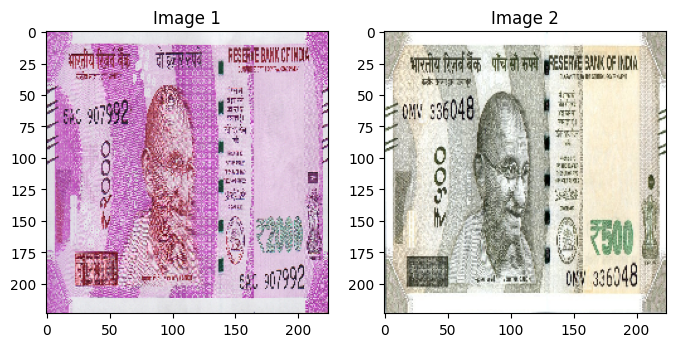

❌ Prediction: Different Class (Real-Fake)


In [23]:
# Ensure the test image pair has the correct shape
# Reshape by removing the extra dimension
image1 = image1.reshape(1, 224, 224, 3)  # Remove extra dimension
image2 = image2.reshape(1, 224, 224, 3)  # Remove extra dimension


# Model prediction
prediction = siamese_model.predict([image1, image2])[0][0]

# Show images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image1[0])  # Remove batch dimension for display
axes[0].set_title("Image 1")
axes[1].imshow(image2[0])  # Remove batch dimension for display
axes[1].set_title("Image 2")
plt.show()

# Print Prediction
if prediction > 0.5:
    print("✅ Prediction: Same Class (Real-Real or Fake-Fake)")
else:
    print("❌ Prediction: Different Class (Real-Fake)")

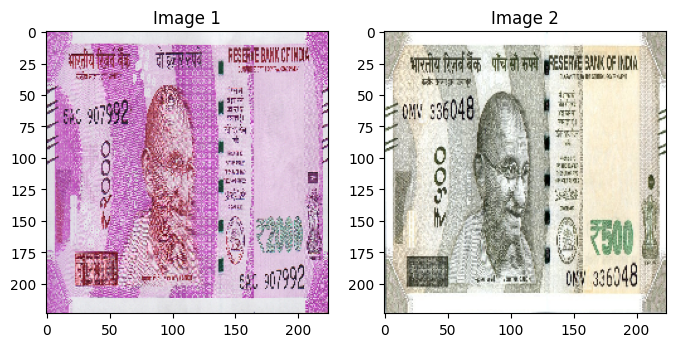

In [24]:
# Show images (remove batch dimension)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image1[0])  # Use image1[0] to remove batch dimension
axes[0].set_title("Image 1")
axes[1].imshow(image2[0])  # Use image2[0] to remove batch dimension
axes[1].set_title("Image 2")
plt.show()


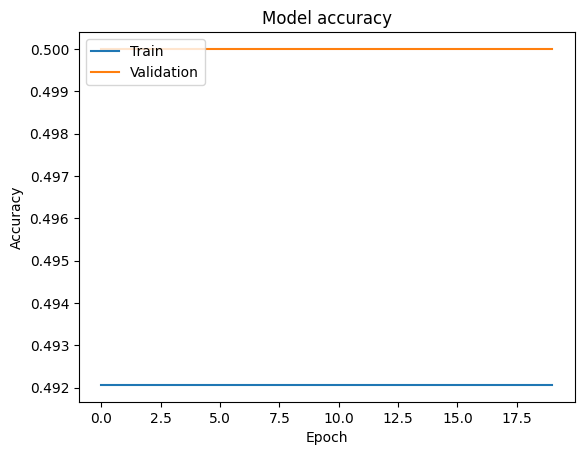

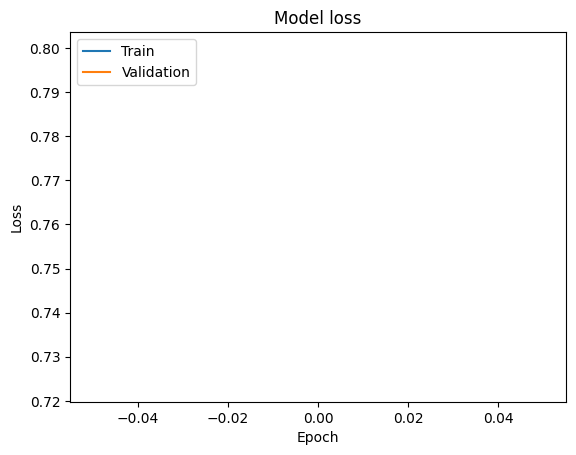

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Accuracy: 0.6666666666666666
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Confusion Matrix:
[[2 0]
 [1 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Training/Validation Accuracy/Loss
# Assuming 'history' is the output from model.fit()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 2. Learning Rate (if you used a learning rate scheduler)
# Assuming you used a LearningRateScheduler callback:
#  lr_scheduler = LearningRateScheduler(some_function)
#  history = model.fit(..., callbacks=[lr_scheduler, ...])

# lrs = history.history['lr']
# epochs = range(1, len(lrs) + 1)
# plt.plot(epochs, lrs)
# plt.title('Learning Rate')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.show()

# 3. Precision, Recall, F1-score
# Get predictions on the test set
y_pred = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# 4. Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

# You might need to install scikit-learn:
# !pip install scikit-learn

In [26]:
# Print Prediction
if prediction > 0.5:
    print("✅ Prediction: Same Class (Real-Real or Fake-Fake)")
else:
    print("❌ Prediction: Different Class (Real-Fake)")

# 📌 Step 7: Save Model for Future Use
model_path = "/content/drive/MyDrive/Siamese_Currency_Model.h5"
siamese_model.save(model_path)
print(f"✅ Model saved at: {model_path}")

❌ Prediction: Different Class (Real-Fake)
✅ Model saved at: /content/drive/MyDrive/Siamese_Currency_Model.h5
